In [1]:
# -*- coding: utf-8 -*-
# @Author: hyzhangyong
# @Date:   2016-06-23 16:21:54
# @Last Modified by:   hyzhangyong
# @Last Modified time: 2016-06-24 00:00:47
import sys
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def colorDetect(image,option=0):
    name = random.randint(0,99)
    img = cv2.imread(image)
    colorImage = img.copy()
    _colorImage = img.copy()
    hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    #cv2.imshow("hsv",hsv)
    #高斯模糊
    img = cv2.GaussianBlur(img,(5,5),0)
    #cv2.imshow("hsv",hsv)
    # 设定蓝色的阈值
    if(option == 0):
        lower=np.array([100,50,50])
        upper=np.array([140,255,255])
    else:
        #黄色
        lower=np.array([15,50,50])
        upper=np.array([40,255,255])

    # 根据阈值构建掩模
    mask=cv2.inRange(hsv,lower,upper)
    # 对原图像和掩模进行位运算
    res=cv2.bitwise_and(img,img,mask=mask)
    gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    #二值化
    ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #cv2.imshow('gray',gray)
    #闭操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(17, 3))  
    closed = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)  
    #cv2.imshow('closed',closed)
    (cnts, _) = cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    boxes = np.choose(cnts)
    #cv2.drawContours(img,cnts,-1,(0,0,255),1)
    imgRs = []
    i = 0
    for cnt in cnts:
        rect = cv2.minAreaRect(cnt)
        x,y,w,h = cv2.boundingRect(cnt)
        if(w<50 or h < 15 or w>h < 1.0):
            continue
        #cv2.rectangle(_colorImage,(x,y),(x+w,y+h),(0,255,0),1)
        #imgCrop = _colorImage[y:y+h,x:x+w]
        imgRs.append((x,y,w,h,rect[2]))
        rs = img[y:y+h,x:x+w]
        #cv2.imshow("============="+str(name),rs)

    #cv2.drawContours(_colorImage, [_box], -1, (0,0,255), 1)
    #cv2.imshow("_colorImage",_colorImage)

    return imgRs

In [3]:
def preprocess(gray):
    # # 直方图均衡化
    # equ = cv2.equalizeHist(gray)
    # 高斯平滑
    gaussian = cv2.GaussianBlur(gray, (3, 3), 0, 0, cv2.BORDER_DEFAULT)
    # 中值滤波
    median = cv2.medianBlur(gaussian, 5)
    # Sobel算子，X方向求梯度
    sobel = cv2.Sobel(median, cv2.CV_8U, 1, 0, ksize = 3)
    # 二值化
    ret, binary = cv2.threshold(sobel, 170, 255, cv2.THRESH_BINARY)
    # 膨胀和腐蚀操作的核函数
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 7))
    # 膨胀一次，让轮廓突出
    dilation = cv2.dilate(binary, element2, iterations = 1)
    # 腐蚀一次，去掉细节
    erosion = cv2.erode(dilation, element1, iterations = 1)
    # 再次膨胀，让轮廓明显一些
    dilation2 = cv2.dilate(erosion, element2,iterations = 5)
    # cv2.imshow('dilation2',dilation2)
    plt.figure(figsize=(100,100))
    plt.imshow(dilation2)
    plt.show()
    cv2.waitKey(0)
    return dilation2





In [4]:
def findPlateNumberRegion(img):
    region = []
    # 查找轮廓
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 筛选面积小的
    for i in range(len(contours)):
        cnt = contours[i]
        # 计算该轮廓的面积
        area = cv2.contourArea(cnt)

        # 面积小的都筛选掉
        if (area < 2000):
            continue

        # 轮廓近似，作用很小
        epsilon = 0.001 * cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # 找到最小的矩形，该矩形可能有方向
        rect = cv2.minAreaRect(cnt)
        print "rect is: "
        print rect

        # box是四个点的坐标
        box = cv2.cv.BoxPoints(rect)
        print('box', box)
        box = np.int0(box)

        # 计算高和宽
        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])
        # 车牌正常情况下长高比在2.7-5之间
        ratio =float(width) / float(height)
        print ratio
        if (ratio > 5 or ratio < 2):
            continue
        region.append(box)

    return region



In [5]:
def detect(img):
    # 转化成灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 形态学变换的预处理
    dilation = preprocess(gray)

    # 查找车牌区域
    region = findPlateNumberRegion(dilation)
    
    print('region', region)

    # 用绿线画出这些找到的轮廓
    for box in region:
        print('***********')
        cv2.drawContours(img, [box], 0, (0, 255, 0), 2)
        ys = [box[0, 1], box[1, 1], box[2, 1], box[3, 1]]
        xs = [box[0, 0], box[1, 0], box[2, 0], box[3, 0]]
        ys_sorted_index = np.argsort(ys)
        xs_sorted_index = np.argsort(xs)

        x1 = box[xs_sorted_index[0], 0]
        x2 = box[xs_sorted_index[3], 0]

        y1 = box[ys_sorted_index[0], 1]
        y2 = box[ys_sorted_index[3], 1]
        
        print('***********')

        img_org2 = img.copy()
        img_plate = img_org2[y1:y2, x1:x2]
        # cv2.imshow('number plate', img_plate)
        plt.figure(figsize=(100,100))
        plt.imshow(img_plate)
        plt.show()
        print('***********')
    """
    cv2.imwrite('number_plate.jpg', img_plate)

    cv2.namedWindow('img', cv2.WINDOW_NORMAL)
    # cv2.imshow('img', img)

    # 带轮廓的图片
    cv2.imwrite('contours.png', img)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """


In [6]:
"""
imagePath = '/workspace/plateRec/test/50.png'
new_image = colorDetect(imagePath,option=0)
plt.figure(figsize=(100,100))
plt.imshow(new_image)
plt.show()
"""

"\nimagePath = '/workspace/plateRec/test/50.png'\nnew_image = colorDetect(imagePath,option=0)\nplt.figure(figsize=(100,100))\nplt.imshow(new_image)\nplt.show()\n"

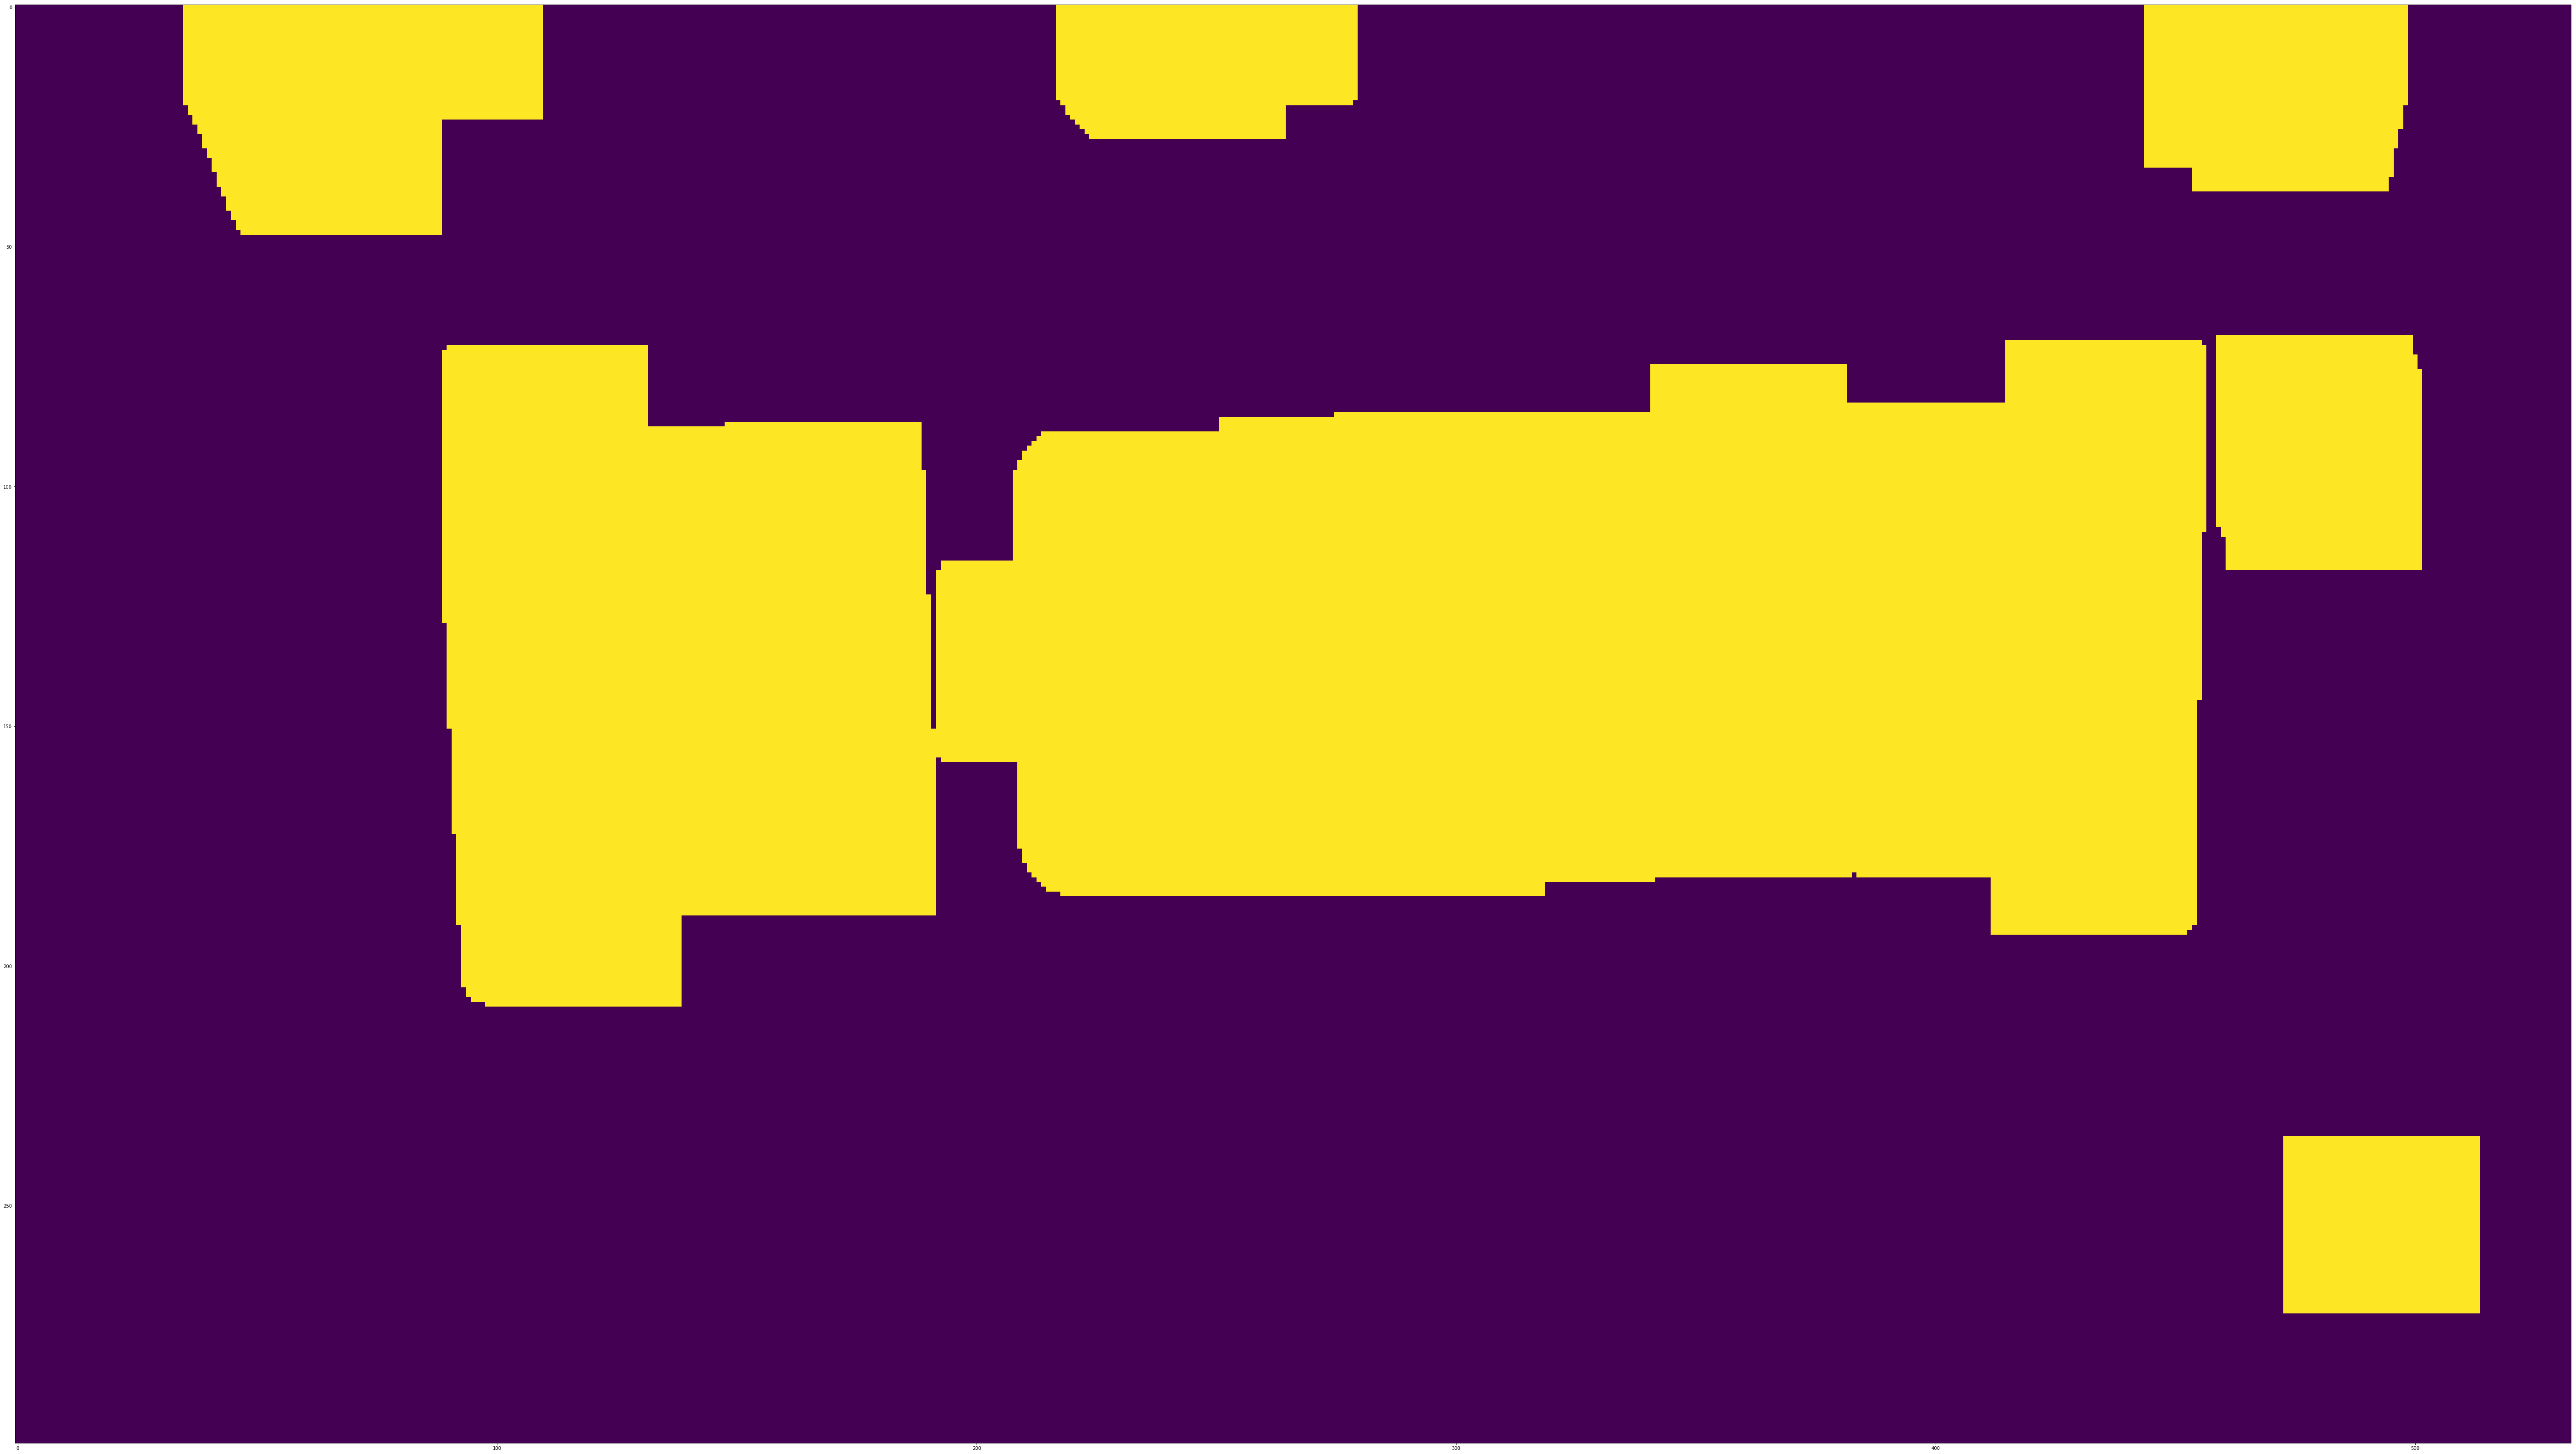

rect is: 
((272.62158203125, 139.01193237304688), (367.17364501953125, 137.14703369140625), -0.17629414796829224)
('box', ((89.24662780761719, 208.15000915527344), (88.82463073730469, 71.00361633300781), (455.99652099609375, 69.87385559082031), (456.41851806640625, 207.02024841308594)))
2.63309352518
rect is: 
((71.99998474121094, 23.999996185302734), (73.99998474121094, 45.99999237060547), 0.0)
('box', ((34.99999237060547, 46.99999237060547), (34.99999237060547, 1.0), (108.9999771118164, 1.0), (108.9999771118164, 46.99999237060547)))
1.64444444444
('region', [array([[ 89, 208],
       [ 88,  71],
       [455,  69],
       [456, 207]])])
***********
***********


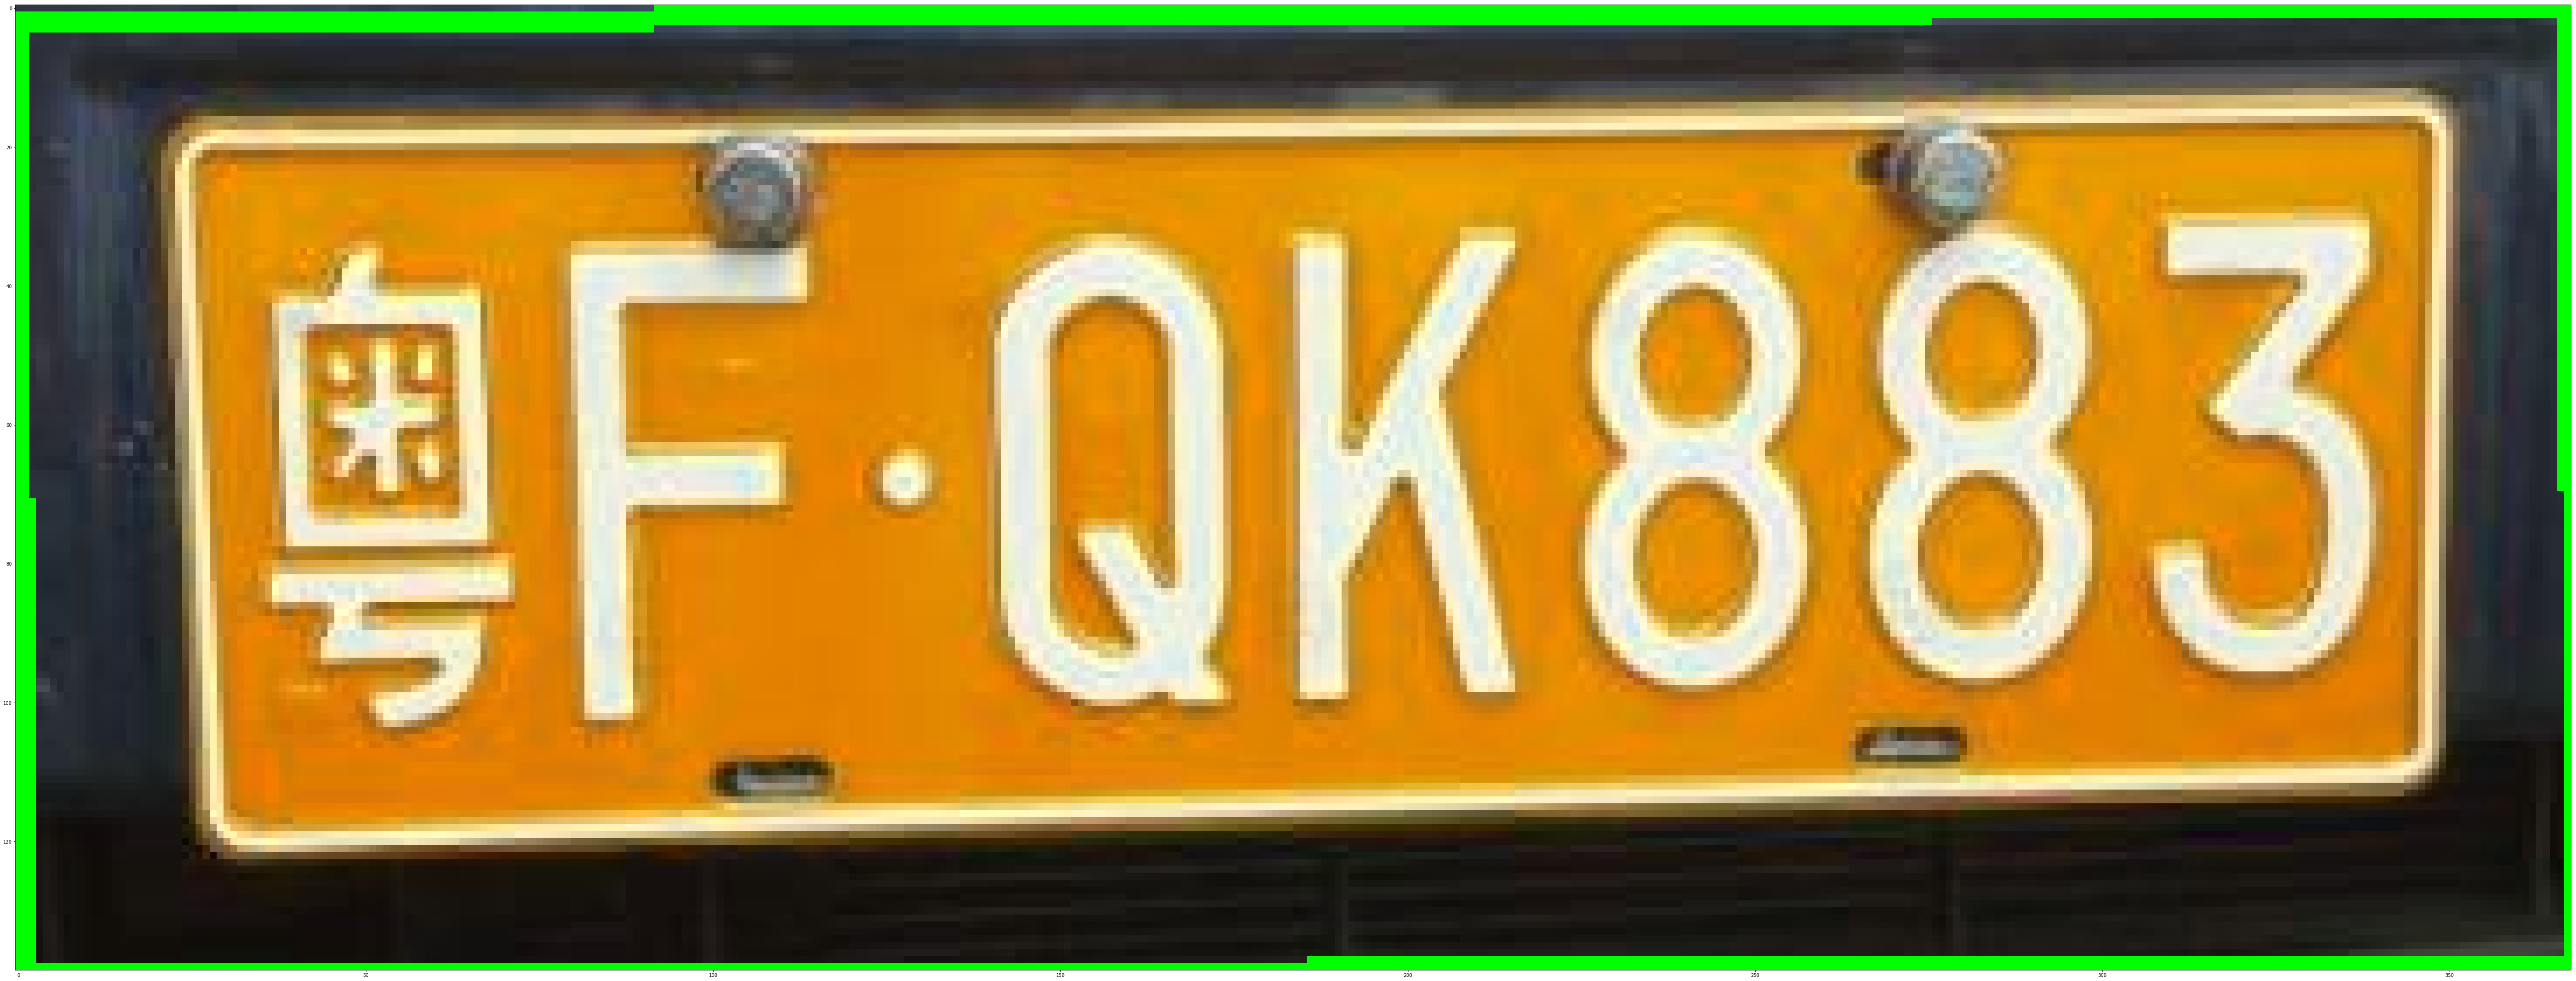

***********


In [7]:
if __name__ == '__main__':
    imagePath = '/workspace/plateRec/test/51.jpg'
    img = cv2.imread(imagePath)
    detect(img)